##### DNN 기반 회귀 모델 구현
- 데이터셋   : iris.csv
- 피쳐/속성  : 4개 Sepal_Length, Sepal_width, Petal_length, Petal_Width
- 타겟/라벨  : 1개 variety
- 학습/방법  : 지도학습 -> 분류 -> 다중분류 (클래스 3개)
- 알고리즘   : 인공신경망(ANN) -> MLP, DNN : 은닉층이 많은 구성
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비

In [1]:
# 모델 관련 모듈 로딩
import torch
import torch.nn as nn  
import torch.nn.functional as F  
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary

# 데이터 관련 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

In [2]:
# 활용 패키지 버전 체크
print(f'torch V.:{torch.__version__}')
print(f'pandas V.:{pd.__version__}')

torch V.:2.4.1
pandas V.:2.0.3


In [3]:
# 데이터 로딩
FILE_PATH='../data/iris.csv'

# CSV => DataFrame
irisDF=pd.read_csv(FILE_PATH)

# 데이터 확인
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


[2] 모델 클래스 설계 및 정의
- 클래스목적 : iris 데이터를 학습 및 추론
- 클래스이름 : irisRegModel
- 부모클래스 : nn.Module
- 매개 변수 : 층별 입출력 개수 고정하기 때문에 필요 x!
- 속성 필드 : 
- 기능 역할 : __ init__() : 모델 구조 설정, forward() : 순방향 학습 <= 오버라이딩(overriding) - [상속 시 가능!]
- 클래스구조
    * 입력층 : 입력 3개(피쳐)  출력 10개 (퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개       출력 30개 (퍼셉트론/뉴런 30개 존재)
    * 출력층 : 입력 30개       출력 1개 (너비값)

- 활성화함수
    * 클래스 형태 ==> ex) nn.MESLoss, nn.ReLU ==> __ init__(self) 메서드
    * 함수 형태 ==> torch.nn.functional 아래에 ==> forward(self) 메서드

In [5]:
labels=dict(zip(irisDF['variety'].unique().tolist(),range(3)))
print(f'{labels}')

irisDF['variety'] = irisDF['variety'].replace(labels)

{'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


In [7]:
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


[2] 모델 클래스 설계 및 정의 
- 클래스목적 : iris 데이터를 학습 및 추론
- 클래스이름 : irisMCFModel
- 부모클래스 : nn.Module
- 매개 변수 : 층별 입출력 개수 고정하기 때문에 필요 x!
- 속성 필드 : 
- 기능 역할 : __ init__() : 모델 구조 설정, forward() : 순방향 학습 <= 오버라이딩(overriding) - [상속 시 가능!]
- 클래스구조
    * 입력층 : 입력 4개(피쳐)  출력 10개 (퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개       출력 5개 (퍼셉트론/뉴런 30개 존재)
    * 출력층 : 입력 5개        출력 3개 (퍼셉트론/뉴런 3개 존재 : 다중분류)

- 활성화함수
    * 클래스 형태 ==> ex) nn.MESLoss, nn.ReLU ==> __ init__(self) 메서드
    * 함수 형태 ==> torch.nn.functional 아래에 ==> forward(self) 메서드

In [8]:
class irisMCFModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.in_layer = nn.Linear(4,10) # 입력층
        self.h_layer = nn.Linear(10, 5) # 은닉층
        self.out_layer = nn.Linear(5, 3) # 다중분류 : 'setosa', versicolor, virginica

    
    def forward(self, x):
        # - 입력층
        y = F.relu(self.in_layer(x))

        # - 은닉층 : 10개의 숫자 값(>=0)
        y = F.relu(self.h_layer(y))

        # - 출력층 : 5개의 숫자 값(>=0) * 손실함수 CrossEntropyLoss의 내부에서 softmax 진행 
        return self.out_layer(y)

        

In [9]:
## 모델 인스턴스 생성
model= irisMCFModel()

print(model)

irisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (h_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [10]:
# 메모리정보확인
summary(model, input_size=(150,4)) #첫번째 데이터양, 두번째 피쳐수

Layer (type:depth-idx)                   Output Shape              Param #
irisMCFModel                             [150, 3]                  --
├─Linear: 1-1                            [150, 10]                 50
├─Linear: 1-2                            [150, 5]                  55
├─Linear: 1-3                            [150, 3]                  18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

[3] 데이터셋 클래스 설계 및 정의
- 데이터셋 : iris.csv
- 피쳐_개수 : 3개
- 타겟_개수 : 1개
- 클래스이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성_필드 : featureDF, targetDF, n_rows, n_features
- 필수메서드 : 
    * __ init__(self): 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * __ len__(self): 데이터의 개수 반환
    * __ getitem__(self, index): 특정 인덱스의 피쳐와 타겟 반환

In [11]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)
        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [12]:
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[irisDF.columns[-1:]]

irisDS=IrisDataset(featureDF, targetDF)

irisDL=DataLoader(irisDS)

for feature, label in irisDL:
    print(feature.shape, label.shape)

torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([1, 4]) torch.Size([1, 1])
torch.Size([

[4] 학습 준비 
- 학습 횟수 : EPOCH          <- 처음~ 끝까지 공부하는 단위
- 배치 크기 : BATCH_SIZE     <- 한번에 학습할 데이터셋 양
- 위치 지정 : DEVICE         <- 탠서 저장 및 실행 위치 (GPU/CPU)
- 학 습 률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001 ~ 0.1 (낮을수록 촘촘히)

In [14]:
### 학습 진행 관련 설정
EPOCHS = 100
BATCH_SIZE = 10
BATCH_CNT = irisDF.shape[0]//BATCH_SIZE
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001


- 인스턴스/객체 : 모델, 데이터셋, 최적화, (손실함수), (성능지표)

In [15]:
# 모델 인스턴스
model=irisMCFModel()

# 데이터셋 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)
print(f'[X_train(shape): {X_train.shape} (type): {type(X_train)}], X_test: {X_test.shape}, X_val: {X_val.shape}')
print(f'[y_train(shape): {y_train.shape} (type): {type(y_train)}], y_test: {y_test.shape}, y_val: {y_val.shape}')

trainDS=IrisDataset(X_train, y_train)
valDS=IrisDataset(X_val, y_val)
testDS=IrisDataset(X_test, y_test)

# - 학습용 데이터로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

[X_train(shape): (84, 4) (type): <class 'pandas.core.frame.DataFrame'>], X_test: (38, 4), X_val: (28, 4)
[y_train(shape): (84, 1) (type): <class 'pandas.core.frame.DataFrame'>], y_test: (38, 1), y_val: (28, 1)


- 최적화, 손실함수 인스턴스 생성

In [16]:
# 최적화 인스턴스 model.parameters() w,b 전달
optimzer=optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 다중분류 CrossEntropyLoss

cross_loss = nn.CrossEntropyLoss()

[5] 학습 진행

In [17]:
# 학습 효과 확인
loss_history, score_hisotry = [[],[]], [[], []] #train ,val
CNT=len(trainDL)
print(f'new BATCH_CNT : {CNT}')
# 학습 모드로 모델 설정

for epoch in range(1, EPOCHS):
    model.train()

    loss_total, score_total = 0,0
    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y = model(featureTS)

        # 손실 계산 : nn.crossEntropyLoss 는 타겟이 0D나 1D, 타입은 long
        loss = cross_loss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()

        # 성능평가
        score=MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1))
        score_total += score.item()

        # 최적화 진행
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()

    # 검증모드
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 평가
        pre_val = model(val_featureTS)

        # 손실
        loss_val = cross_loss(pre_val, val_targetTS.reshape(-1).long())

        # 성능평가
        score_val = MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))

    
    # 에포크당 손실값과 성능평가값 저장
    loss_history[0].append(loss_total/epoch)
    score_hisotry[0].append(score_total/epoch)

    loss_history[1].append(loss_val)
    score_hisotry[1].append(score_val)

    print(f'{epoch}/{EPOCHS} => [TRAIN] LOSS: {loss_history[0][-1]} SCORE: {score_hisotry[0][-1]}')
    print(f'[VAL] LOSS: {loss_history[1][-1]} SCORE: {score_hisotry[1][-1]}')

new BATCH_CNT : 9
1/100 => [TRAIN] LOSS: 10.412635445594788 SCORE: 1.4797924607992172
[VAL] LOSS: 1.19307541847229 SCORE: 0.10101010650396347
2/100 => [TRAIN] LOSS: 5.109391391277313 SCORE: 0.7398962303996086
[VAL] LOSS: 1.1640108823776245 SCORE: 0.10101010650396347
3/100 => [TRAIN] LOSS: 3.346114675203959 SCORE: 0.4932641535997391
[VAL] LOSS: 1.1403610706329346 SCORE: 0.10101010650396347
4/100 => [TRAIN] LOSS: 2.4720583260059357 SCORE: 0.3699481151998043
[VAL] LOSS: 1.1202919483184814 SCORE: 0.10101010650396347
5/100 => [TRAIN] LOSS: 1.9556480646133423 SCORE: 0.29595849215984343
[VAL] LOSS: 1.1087195873260498 SCORE: 0.10101010650396347
6/100 => [TRAIN] LOSS: 1.6186065077781677 SCORE: 0.24663207679986954
[VAL] LOSS: 1.1008702516555786 SCORE: 0.10101010650396347
7/100 => [TRAIN] LOSS: 1.3788548367364066 SCORE: 0.21139892297131674
[VAL] LOSS: 1.0934666395187378 SCORE: 0.10101010650396347
8/100 => [TRAIN] LOSS: 1.1991135627031326 SCORE: 0.18497405759990215
[VAL] LOSS: 1.0858973264694214 S

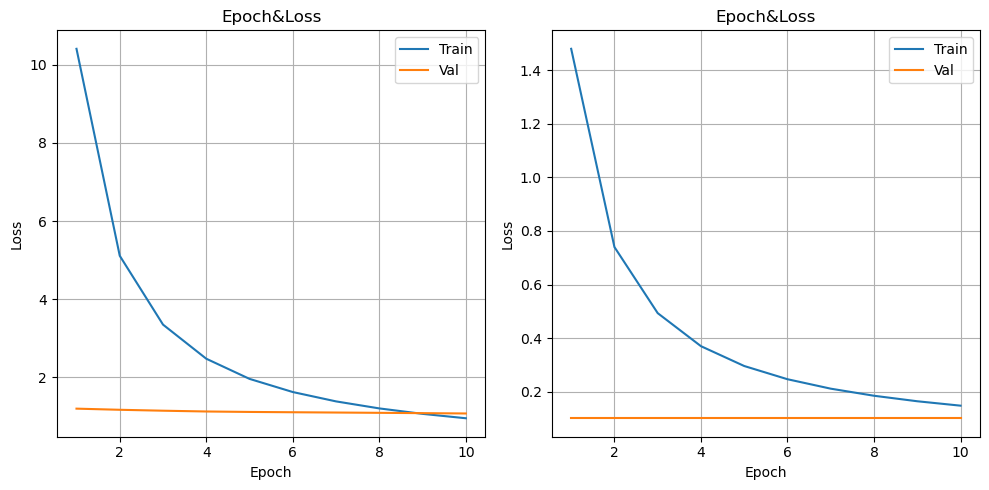

In [18]:
# 학습 후 loss 시각화

THRESHOLD=10
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss_history[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss_history[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), score_hisotry[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), score_hisotry[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Epoch&Loss')
plt.tight_layout()
plt.show()